In [1]:
%load_ext autoreload
%autoreload 2

#Imports from this projects
import auxiliary.util as util
util.set_wd_to_package_root()
import auxiliary.config as config
import auxiliary.grid2op_util as g2o_util
from auxiliary.generate_action_space import action_identificator
import data_preprocessing_analysis.imitation_data_preprocessing as idp

#Mathematics
import math
import numpy as np
from scipy.stats import entropy
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix

#Collections
import collections
from collections import Counter

#File manipulation
import os
import json
from pathlib import Path

import pandas as pd #Data manipulation & analsysis
import grid2op #Grid simulation
import matplotlib.pyplot as plt #Plotting
import ipdb #Debugger
import re #Regular expressions
import functools #Higher-order functions
from tqdm import tqdm #Progress bar

In [2]:
config = config.get_config()

In [3]:
processed_data_path = config['paths']['processed_tutor_imitation']
con_matrix_path = config['paths']['con_matrix_cache']
fstats_path = config['paths']['feature_statistics']

chronics_excluded = [310, 446, 777]

In [4]:
config['paths']['processed_tutor_imitation']

'data/processed_tutor_data/'

# Processed Data Analysis

The next block defines several data aggregates, such as counters. The processed data is loaded a file at a time, gradually filling the data aggregates.

In [5]:
n_sub = 14

#Inbstantiate the counter objects
counters = {
    'n_datapoints':0,
    'n_days_completed':0,
    'n_chronics':0,
    'set_hash': collections.Counter(),
    'res_hash': collections.Counter(),
    'tv_hash': collections.Counter(),
    'sub_changed': (n_sub+1) * [0],
    'changed_subs_n': n_sub * [0],
    'sub_info': []
}
        
# To count numpy arrays, we index their counters with hashes, stored in hash dictionaries:
hash_to_act = {} #'Set'-action hashes
hash_to_tv = {} #Topology vector hashes
hash_to_res = {} #Resulting (i.e. post-action) topology vector hashes


for f in tqdm(list(Path(processed_data_path).rglob('*.json'))):
    with open(f, 'r') as file:
            dps = json.loads(file.read())
    
    counters['n_chronics']+=1
    counters['n_days_completed']+=dps[0]['dayscomp']
    for dp in dps:
        #Increase n. datapoints
        counters['n_datapoints']+=1
        
        #Count set_topo_vect
        hsh_set = util.hash_nparray(np.array(dp['set_topo_vect']))
        if hsh_set not in hash_to_act:
            hash_to_act[hsh_set] = dp['set_topo_vect']
        counters['set_hash'][hsh_set]+=1
        
        #Count res_topo_vect
        hsh_res = util.hash_nparray(np.array(dp['res_topo_vect']))
        if hsh_res not in hash_to_res:
            hash_to_res[hsh_res] = dp['res_topo_vect']
        counters['res_hash'][hsh_res]+=1
        
        #Count topo_vect
        hsh_tv = util.hash_nparray(np.array(dp['topo_vect']))
        if hsh_tv not in hash_to_tv:
            hash_to_tv[hsh_tv] = dp['topo_vect']
        counters['tv_hash'][hsh_tv]+=1
        
        #Count substations affected
        action_per_sub = g2o_util.tv_groupby_subst(dp['set_topo_vect'],dp['sub_info'])
        try:
            changed_subs_id = [np.any(a) for i,a in enumerate(action_per_sub)].index(True)
            counters['sub_changed'][changed_subs_id] += 1
        except:
            counters['sub_changed'][-1] += 1

        #Count topological depth of resulting topologies
        #ASSUMPTION: reference topology is the topology where all objects are connected to bus 1
        res_per_sub = g2o_util.tv_groupby_subst(dp['res_topo_vect'],dp['sub_info'])
        changed_subs_n = sum([2 in res for i,res in enumerate(res_per_sub)])
        counters['changed_subs_n'][changed_subs_n] += 1
        
        #Set sub info
        counters['sub_info'] = dp['sub_info']


100%|██████████| 997/997 [00:13<00:00, 74.04it/s]


In [6]:
counters

{'n_datapoints': 51716,
 'n_days_completed': 27916,
 'n_chronics': 997,
 'set_hash': Counter({-4195172118538912187: 14471,
          4306545410962768278: 4867,
          -2319291396094100394: 7408,
          7039534209449063035: 749,
          -3440762522916116330: 1213,
          4240861238512522798: 50,
          -4179780154151324996: 5586,
          -6470843412405813473: 3857,
          41542179190133383: 1391,
          3228813115425595761: 232,
          -162862040715334225: 217,
          -7213147112177905295: 790,
          -4999325107680832128: 2652,
          -2784675772113614656: 2436,
          -6101991991171005634: 214,
          -4784270093142056454: 174,
          -4115893601745814788: 1105,
          9117996544760733830: 1163,
          -8960671512442512204: 301,
          -2799230345247592790: 91,
          6557639599837853623: 708,
          -2662539558387147027: 144,
          4805863585228395727: 278,
          -8475792596596817246: 114,
          -209542232169748089

#### Number of chronics

In [7]:
print(f"Chronics: {counters['n_chronics']}")

Chronics: 997


#### Days completed

In [8]:
print(f"Days completed: {counters['n_days_completed']}")
print(f"Fraction days completed: {counters['n_days_completed']/(28*counters['n_chronics'])}")

Days completed: 27916
Fraction days completed: 1.0


#### Number of actions/datapoints

In [9]:
#Using the term 'action' here instead of 'datapoint'
print(f"Actions: {counters['n_datapoints']}")
print(f"Mean actions per day: {counters['n_datapoints']/(28*counters['n_chronics'])}")

Actions: 51716
Mean actions per day: 1.8525576730190572


#### Action statistics

In [10]:
print(f"Distinct actions: {len(counters['set_hash'])}")

Distinct actions: 64


In [11]:
do_nothing_hash = [h for h,t in hash_to_act.items() if sum(t)==0][0]
print(f"Do-nothing actions: {counters['set_hash'][do_nothing_hash]}")
print(f"Fraction do-nothing actions: {counters['set_hash'][do_nothing_hash]/counters['n_datapoints']}")

Do-nothing actions: 708
Fraction do-nothing actions: 0.013690153917549694


In [12]:
print(f"Action entropy: {entropy(list(counters['set_hash'].values()))}")

Action entropy: 2.4990634380544265


#### Action distribution plots

We transform the actions into the representation:

(affected substation index, 'set' configuration of objects at this substation)

do-nothing actions are simply transformed into '-'

In [13]:
#Getting actions into format so that actions at substations
standard_sub_info = [3, 6, 4, 6, 5, 6, 3, 2, 5, 3, 3, 3, 4, 3]
do_nothing_hash = [h for h,t in hash_to_act.items() if sum(t)==0][0]

transformed_act_counter = collections.Counter()

# Filling in the counter for the transformed actions
for h,c in counters['set_hash'].items():
    a = hash_to_act[h]
    a_per_substation = g2o_util.tv_groupby_subst(a,standard_sub_info)
    
    if h == do_nothing_hash:
        transformed_act_counter[-1] += c
    else:
        changed_sub_id = [np.any(a) for a in a_per_substation].index(True)
        action = (changed_sub_id,tuple(a_per_substation[changed_sub_id]))
        transformed_act_counter[action] += c
        
#Gettings the keys of this counter
keys = list(transformed_act_counter.keys())
keys = sorted([t for t in keys if type(t)==tuple])
keys = [-1] + keys

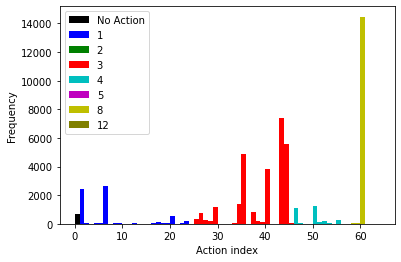

In [78]:
colormap = {
    -1:'k',
    1:'b',
    2:'g',
    3:'r',
    4:'c',
    5:'m',
    8:'y',
    12:'olive',
}

weight = [transformed_act_counter[i] for i in keys]
_, _, patches = plt.hist(range(len(weight)),weights=weight,bins=range(len(weight)+1))


#Applying colors
labels_set = []
for j,t in enumerate(keys[:-1]):
    if type(t) == int:
        continue
    patches[j].set_facecolor(colormap[t[0]])
    if t[0] not in labels_set:
        patches[j].set_label(t[0])
        labels_set.append(t[0])
patches[0].set_facecolor(colormap[-1])
patches[0].set_label("No Action")

plt.xlabel('Action index')
plt.ylabel("Frequency")
plt.gca().legend()

Text(0.5, 0, 'Action index ordered by frequency')

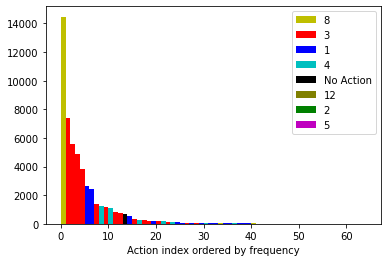

In [97]:
weight = [c for _,c in transformed_act_counter.most_common()]
_, _, patches = plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)+1))

#Applying colors
labels_set = []
for i,(v,_) in enumerate(transformed_act_counter.most_common()):
    if type(v) == int:
        patches[i].set_facecolor(colormap[-1])
        patches[i].set_label("No Action")
        continue
    patches[i].set_facecolor(colormap[v[0]])
    if v[0] not in labels_set:
        patches[i].set_label(v[0])
        labels_set.append(v[0])


#_ = [patches[i].set_facecolor(colormap[v if v==-1 else v[0]])
# for i,(v,_) in enumerate(transformed_act_counter.most_common())]

plt.gca().legend()
plt.xlabel('Action index ordered by frequency')



### Starting TV Distribution

Text(0, 0.5, 'Frequency')

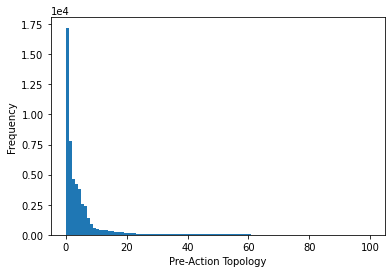

In [30]:
tv_counter = counters['tv_hash']
val, weight = zip(*[(i, v) for i,(k,v) in enumerate(tv_counter.most_common())])
plt.hist(val[0:100], weights=weight[0:100],bins=val[0:101])

patches[0].set_facecolor(colormap[-1])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("Pre-Action Topology by Frequency")
plt.ylabel("Frequency")

### Resulting TV Distribution

Text(0, 0.5, 'Frequency')

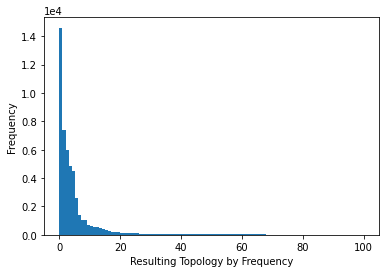

In [31]:
res_counter = counters['res_hash']
val, weight = zip(*[(i, v) for i,(k,v) in enumerate(res_counter.most_common())])
plt.hist(val[0:100], weights=weight[0:100],bins=val[0:101])

patches[0].set_facecolor(colormap[-1])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("Resulting Topology by Frequency")
plt.ylabel("Frequency")

### Substations acted on

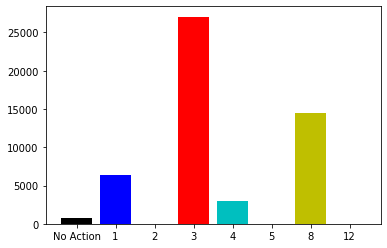

In [111]:
substations_with_actions = [-1,1,2,3,4,5,8,12]
colormap = {
    -1:'k',
    1:'b',
    2:'g',
    3:'r',
    4:'c',
    5:'m',
    8:'y',
    12:'k',
}

patches = plt.bar(['No Action'] + [str(b) for b in substations_with_actions][1:],
                np.array(counters['sub_changed'])[substations_with_actions])
_ = [p.set_facecolor(c) for p,c in zip(patches,colormap.values())]

### Topological Depth

In [19]:
do_nothing_hash = [h for h,t in hash_to_act.items() if sum(t)==0][0]

def mean_index(lst):
    return np.sum(np.array([i*v for i,v in enumerate(lst)]))/sum(lst)

Text(0, 0.5, 'Frequency')

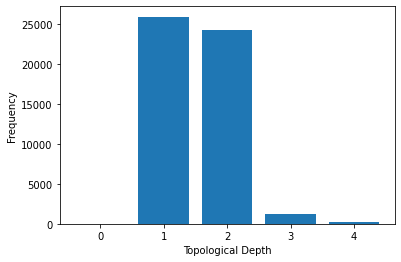

In [113]:
nr_nonzero = np.count_nonzero(counters['changed_subs_n'])

plt.bar([str(n) for n in range(n_sub)][0:nr_nonzero],list(counters['changed_subs_n'])[0:nr_nonzero])
plt.title('')

plt.xlabel("Topological Depth")
plt.ylabel("Frequency")